In [1]:
from shearpy import generate_cold_ice_mask
import geopandas as gpd

In [6]:
from shearpy import ShearStressData

In [11]:
ss = ShearStressData.from_shp("/nfs/annie/cm15ogp/data/shear_stress/eurasia/regions.shp")

In [23]:
ss.gdf[(ss.gdf['category'] == "ice_stream") & (ss.gdf['layer'] == "lgm_ice_streams")]

,category,def_val,layer,geometry
740,ice_stream,10000,lgm_ice_streams,"POLYGON ((-6.23215 56.67938, -6.31806 56.57508..."
741,ice_stream,10000,lgm_ice_streams,"POLYGON ((-5.57151 54.24241, -4.91798 54.09706..."
742,ice_stream,10000,lgm_ice_streams,"POLYGON ((-6.50183 58.97791, -6.48142 58.94586..."
743,ice_stream,10000,lgm_ice_streams,"POLYGON ((-4.85487 59.95038, -4.69405 59.82413..."
744,ice_stream,10000,lgm_ice_streams,"POLYGON ((-2.75165 60.14038, -2.88996 60.03841..."
...,...,...,...,...
834,ice_stream,10000,lgm_ice_streams,"POLYGON ((15.41495 53.92983, 14.78981 53.83269..."
835,ice_stream,10000,lgm_ice_streams,"POLYGON ((15.52599 55.51942, 15.18322 55.15525..."
836,ice_stream,10000,lgm_ice_streams,"POLYGON ((12.98410 55.56527, 12.97980 55.39166..."
837,ice_stream,10000,lgm_ice_streams,"POLYGON ((-6.23684 52.17819, -6.29128 52.03931..."


In [ ]:
pgm: 67
lgm: 99


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapy import calc_close_holes

In [154]:
max_margin = gpd.read_file("data/margins/batchelor_eurasia_mis6_max/margin.shp")
ss_map_orig = gpd.read_file("/nfs/annie/cm15ogp/data/shear_stress/eurasia/regions.shp")

ss_map = ss_map_orig.to_crs(max_margin.crs)

<Axes: >

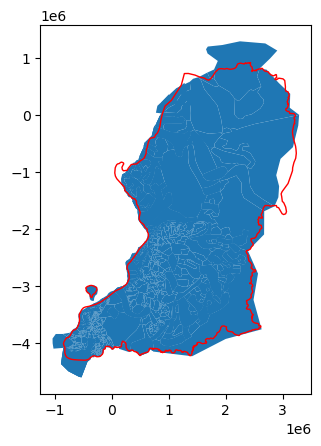

In [155]:
fig, ax = plt.subplots()
ss_map.plot(ax=ax)
max_margin.plot(ax=ax, color=(0,0,0,0), edgecolor="red")

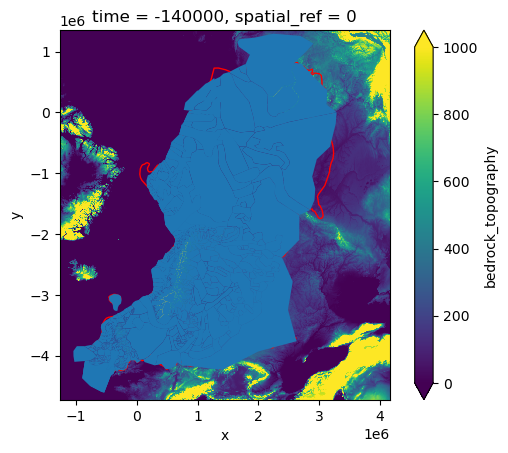

In [156]:
fig, ax = plt.subplots()
ss_map.plot(ax=ax,zorder=3)
max_margin.plot(ax=ax, color=(0,0,0,0), edgecolor="red",zorder=2)
modern_topo_da = xr.open_dataset("../../data/simulations/pgm_batchelor_topo0.nc").bedrock_topography.sel(time=-140000)
modern_topo_da.plot(ax=ax,zorder=1,vmin=0,vmax=1000)

In [157]:
merged_ss_map = calc_close_holes(ss_map.dissolve().explode(index_parts=False).iloc[0].geometry)
exterior_regions = max_margin.geometry.iloc[1].difference(merged_ss_map)
exterior_regions_gdf = gpd.GeoDataFrame(
    geometry=[exterior_regions], 
    crs=max_margin.crs
).explode(index_parts=False)


<Axes: >

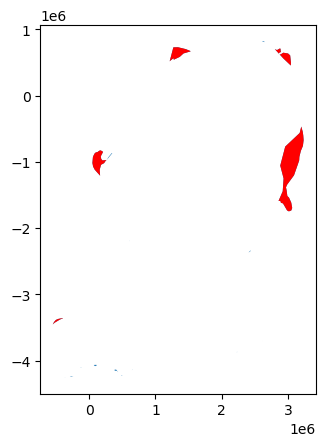

In [159]:
area_sorted = np.argsort(exterior_regions_gdf.area.values)
fig, ax = plt.subplots()
exterior_regions_gdf.plot(ax=ax)
exterior_regions_gdf.iloc[area_sorted[-6:]].plot(ax=ax,color="red")

<Axes: >

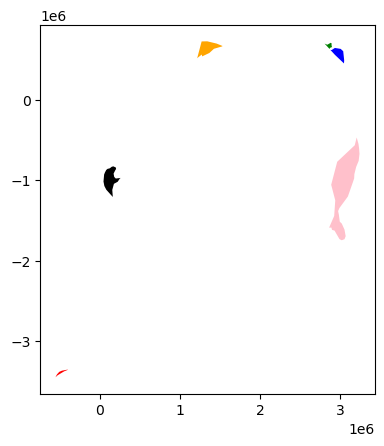

In [161]:
new_regions = exterior_regions_gdf.iloc[area_sorted[-6:]].copy()
fig, ax = plt.subplots()
new_regions.iloc[[0]].plot(ax=ax, color="red")
new_regions.iloc[[1]].plot(ax=ax, color="green")
new_regions.iloc[[2]].plot(ax=ax, color="blue")
new_regions.iloc[[3]].plot(ax=ax, color="orange")
new_regions.iloc[[4]].plot(ax=ax, color="black")
new_regions.iloc[[5]].plot(ax=ax, color="pink")

In [162]:
new_regions['category'] = [
    'marine_sediment', 
    'onshore_sediment', 
    'onshore_sediment', 
    'marine_sediment', 
    'marine_sediment', 
    'onshore_sediment'
]
new_regions['def_val'] = [10000]*6
new_regions['layer'] = ['sediment']*6
new_regions.index = [906, 907, 908, 909, 910, 911]

In [163]:
ss_map_new = gpd.GeoDataFrame(pd.concat([ss_map,new_regions])).to_crs(ss_map_orig.crs)
ss_map_new.to_file("/nfs/annie/cm15ogp/data/shear_stress/eurasia_expanded/regions.shp")

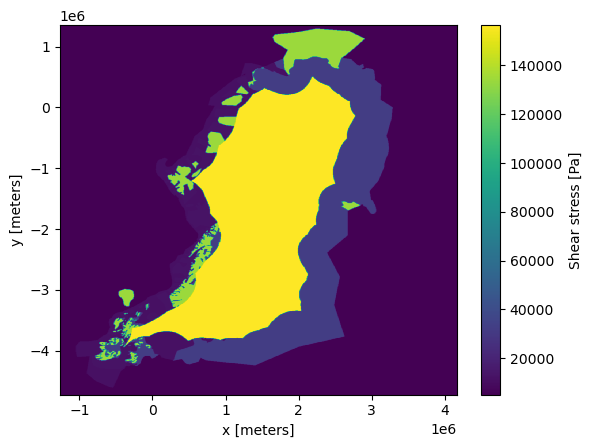

In [3]:
import xarray as xr
xr.open_dataset("shearstress/10/0.nc").z.plot()

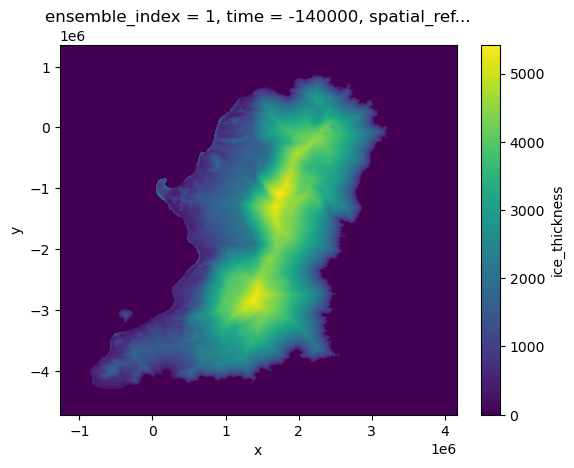

In [24]:
import xarray as xr
xr.open_dataset("../../data/simulations/pgm_batchelor_topo1.nc").sel(ensemble_index=1, time=-140000).ice_thickness.plot()

In [44]:
np.all([False, True])

False

  0%|          | 0/30 [00:00<?, ?it/s]

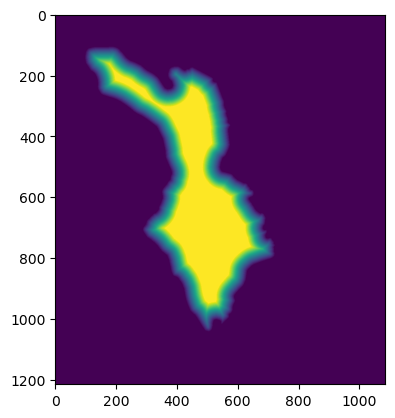

In [17]:
import numpy as np

dx = 5000
dy = 5000
x_min = -1265453.0
x_max = 4159547.0
y_min = -4722734.8
y_max = 1352265.2
grid_x = np.arange(x_min, x_max+dx, dx)
grid_y = np.arange(y_min, y_max+dy, dy)

import matplotlib.pyplot as plt
plt.imshow(generate_cold_ice_mask(
    ice_margin = gpd.read_file("margins/0/0.shp"),
    grid_x = grid_x,
    grid_y = grid_y,
    interior_dist = 1,
    smooth_dist=300,
    order=1,
    resolution=30,
))

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import xarray as xr
import rioxarray
import sys

ens_idx = sys.argv[1]

from shearpy import make_shear_stress_map

shear_stress_map_name = "ely_victor_eurasia"
shear_stress_map_file = "/nfs/annie/cm15ogp/data/shear_stress/eurasia/regions.shp"

dx = 5000
dy = 5000
x_min = -1265453.0
x_max = 4159547.0
y_min = -4722734.8
y_max = 1352265.2
grid_x = np.arange(x_min, x_max+dx, dx)
grid_y = np.arange(y_min, y_max+dy, dy)

grid_crs = '+ellps=WGS84 +proj=laea +lon_0=0.0 +lat_0=90 +x_0=0.0 +y_0=0.0 +no_defs'

num_margins = len([f for f in Path("/nfs/b0029/Data/Oliver/ensembles/lig_sens/margins/0/").iterdir() if f.suffix == ".shp"])

cols = [
    'g_pgm_ice_streams_ice_stream',
    'g_sediment_marine_sediment',
    'g_sediment_onshore_sediment',
    'g_sediment_bedrock',
    'p_ice_stream_interior_dist',
    'p_cold_ice_shear_stress',
    'p_cold_ice_interior_dist',
    'p_hybrid_ice_stream_shear_stress',
    'p_hybrid_ice_stream_dist'
]
param_vals = pd.read_csv("sample.csv", index_col=0)
param_vals = param_vals[cols]

shear_stress_parameters_const = {
    "m_base_map_name": shear_stress_map_name,
    "m_base_map_file": shear_stress_map_file,
    "m_gauss_blur": 1,
    "m_base_value": 5000,
    "m_combine_pattern": "((g_sediment | (g_pgm_ice_streams * p_ice_stream)) | p_hybrid_ice_stream) | p_cold_ice",
    "g_layers": ["sediment", "pgm_ice_streams"],
    "p_processes": ["ice_stream", "cold_ice", "hybrid_ice_stream"],
}

exp_name = ens_idx
values = param_vals.iloc[ens_idx]
margins_dir = f"/nfs/b0029/Data/Oliver/ensembles/lig_sens/margins/{exp_name}/"
for margin_idx in tqdm(range(num_margins)):
    margin_filename = str(Path(margins_dir) / f"{margin_idx}.shp")
    shear_stress_parameters_margins = {
        "p_margin_name": f"interp_{exp_name}",
        "p_margin_time": margin_idx,
        "p_margin_file": margin_filename,
    }
    shearstress_path = Path(f"/nfs/b0029/Data/Oliver/ensembles/lig_sens/shearstress/{exp_name}/")
    shearstress_path.mkdir(exist_ok=True, parents=True)
    shearstress_file = shearstress_path / f"{margin_idx}.nc"

    shear_stress_parameters_var = values.to_dict()
    shear_stress_parameters = {
        **shear_stress_parameters_const, 
        **shear_stress_parameters_var, 
        **shear_stress_parameters_margins,
    }
    if margin_idx >= 9: 
        shear_stress_parameters["m_combine_pattern"] = "(g_sediment | (g_pgm_ice_streams * p_ice_stream)) | p_cold_ice"
    else:
        shear_stress_parameters["m_combine_pattern"] = "((g_sediment | (g_pgm_ice_streams * p_ice_stream)) | p_hybrid_ice_stream) | p_cold_ice"

    make_shear_stress_map(
        grid_x = grid_x, 
        grid_y = grid_y, 
        grid_crs = grid_crs, 
        parameters = shear_stress_parameters,
        save=str(shearstress_file)
    )